In [1]:
import os
import sys
import random
from pathlib import Path
import osgeo  #Needed for use on Windows only
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
%matplotlib inline

In [2]:
sys.path.append(r"../src/collectcube")
from samplegen import *

## Get random sample within polygon

aoi file has crs:epsg:32721


<Axes: >

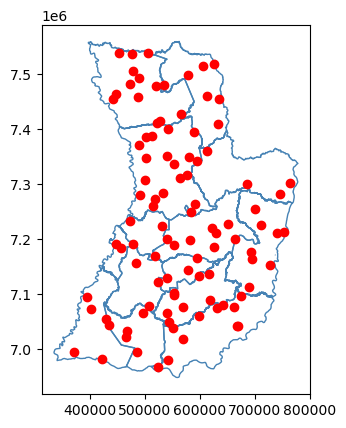

In [3]:
aoi_in = Path("../data/EParaguay.shp")
sampsize = 100
subpoly=None
gs = get_sample_in_poly(aoi_in, sampsize, subpoly)

fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs.plot(ax=ax, color='r')

## Shift points to centroids of ref ras and make sample boxes

ref_ras has crs:EPSG:8858
Reprojecting aoi file to match image crs


<Axes: >

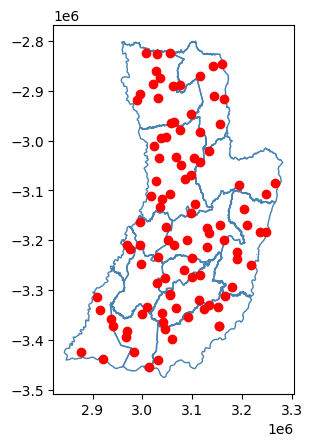

In [4]:
ref_ras = Path("../data/samp_ras.tif")

gs_shift = move_points_to_pixel_centroids(gs, ref_ras, write_pts=False)

## Plot again to make sure that crs is correctly matched
fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
if (gdf.crs != gs_shift.crs):
    print("Reprojecting aoi file to match image crs")
    gdf = gdf.to_crs(gs_shift.crs)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs_shift.plot(ax=ax, color='r')

In [5]:
poly_file_out = "C:/Users/klobw/Desktop/Testing/polys_test8.shp"
pt_file_out = "C:/Users/klobw/Desktop/Testing/pts_test2.shp"
res = 10
    
allpts = get_full_point_file(gs_shift, pt_file_out, res)

boxes = make_pixel_boxes_from_pts(allpts, poly_file_out, res)

<class 'geopandas.geodataframe.GeoDataFrame'>
there are 800 neighbor pixels
there are 900 total pixels


polys overlapping image: 
                                             geometry
0  POLYGON ((3164845.000 -3198865.000, 3164845.00...
1  POLYGON ((3164835.000 -3198855.000, 3164835.00...
2  POLYGON ((3164845.000 -3198855.000, 3164845.00...
3  POLYGON ((3164855.000 -3198855.000, 3164855.00...
4  POLYGON ((3164835.000 -3198865.000, 3164835.00...
5  POLYGON ((3164855.000 -3198865.000, 3164855.00...
6  POLYGON ((3164835.000 -3198875.000, 3164835.00...
7  POLYGON ((3164845.000 -3198875.000, 3164845.00...
8  POLYGON ((3164855.000 -3198875.000, 3164855.00...


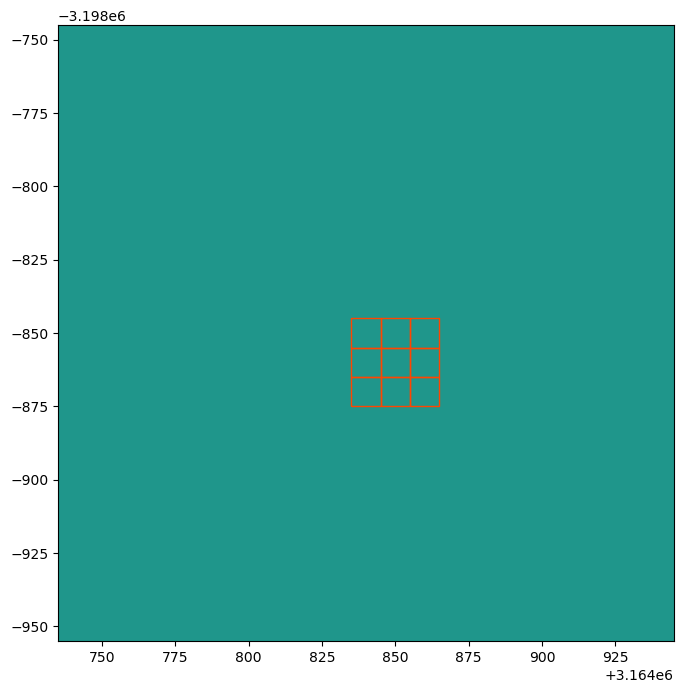

In [6]:
zoom = find_poly_on_image(1, ref_ras, boxes)

## Make pixel table and insert in landcover database

In [7]:
ptsdf = make_pixel_table(allpts)
ptsdf.tail()

,PID,Center,cent_lat,cent_long,cent_X,cent_Y,ransamp
895,0000100_4,0,-24.412946,-55.173986,3194010.0,-3088520.0,1
896,0000100_5,0,-24.412946,-55.173768,3194030.0,-3088520.0,1
897,0000100_6,0,-24.413027,-55.173975,3194010.0,-3088530.0,1
898,0000100_7,0,-24.413027,-55.173866,3194020.0,-3088530.0,1
899,0000100_8,0,-24.413027,-55.173757,3194030.0,-3088530.0,1


In [8]:
local_db_path = 'sqlite:///../data/db_samp/landcover.db'
treat_existing = 'replace' # 'replace' | 'append' | 'fail'
make_pixel_table_in_db(ptsdf, local_db_path, treat_existing)

In [10]:
#with engine.connect() as conn:
#    query = conn.execute(sa.text('SELECT * FROM pixels'))
engine = sa.create_engine(local_db_path, echo=False)
cnx = engine.connect()
df = pd.read_sql_table('pixels', con=cnx)
df.head()

,PID,Center,cent_lat,cent_long,cent_X,cent_Y,ransamp
0,0000001_0,1,-22.867457,-56.362245,3101770.0,-2898620.0,1
1,0000002_0,1,-26.510435,-55.565884,3133080.0,-3344300.0,1
2,0000003_0,1,-24.315817,-55.928262,3125930.0,-3076620.0,1
3,0000004_0,1,-26.612204,-56.082175,3084860.0,-3356650.0,1
4,0000005_0,1,-25.540251,-56.431695,3065810.0,-3226280.0,1
